In [40]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)

import mneflow as mf
import mneflow
import tensorflow as tf
import numpy as np
from mneflow.models import BaseModel, LFCNN
from utils.machine_learning.designer import ModelDesign, ParallelDesign, LayerDesign
from utils.machine_learning.analyzer import ModelAnalyzer
from mneflow.layers import DeMixing, LFTConv, TempPooling, Dense
from mne.datasets import multimodal
import mne
from utils.machine_learning.confusion import ConfusionEstimator
from utils.machine_learning import one_hot_decoder
import sklearn.metrics as sm
import matplotlib.pyplot as plt
from mne import channels, evoked, create_info

from scipy.signal import freqz, welch
from scipy.stats import spearmanr

In [2]:
mne.set_log_level(verbose='CRITICAL')
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)
cond = raw.acqparser.get_condition(raw, None)
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs = epochs.pick_types(meg='grad')
X = np.array([])
Y = list()
for i, epochs in enumerate(epochs_list):
    data = epochs.get_data()
    if i == 0:
        X = data.copy()
    else:
        X = np.append(X, data, axis=0)
    Y += [i for _ in range(data.shape[0])]

Y = np.array(Y)
X = np.array([X[i, epochs._channel_type_idx['grad'], :] for i, _ in enumerate(X)])
original_X = X.copy()
original_Y = Y.copy()

import_opt = dict(savepath='../tfr/',
                  out_name='mne_sample_epochs',
                  fs=600,
                  input_type='trials',
                  target_type='int',
                  picks={'meg':'grad'},
                  scale=True,  # apply baseline_scaling
                  crop_baseline=True,  # remove baseline interval after scaling
                  decimate=None,
                  scale_interval=(0, 60),  # indices in time axis corresponding to baseline interval
                #   n_folds=5,  # validation set size set to 20% of all data
                  n_folds=5,
                  overwrite=True,
                  segment=False,
                  test_set='holdout'
)
lf_params = dict(n_latent=32, #number of latent factors
                  filter_length=17, #convolutional filter length in time samples
                  nonlin = tf.nn.relu,
                  padding = 'SAME',
                  pooling = 5,#pooling factor
                  stride = 5, #stride parameter for pooling layer
                  pool_type='max',
                  model_path = import_opt['savepath'],
                  dropout = .5,
                  l1_scope = ["weights"],
                  l1=3e-3)


In [57]:
info = epochs.load_data().copy().pick_types('grad').info
pos = np.array([ch['loc'][:3] for ch in info['chs']])

In [ ]:
epochs.load_data().copy().pick_types('grad').average().plot_sensors(show_names=True)

In [58]:
adj = list()
for ch1 in pos:
    row = list()
    for ch2 in pos:
        row.append(
            np.sqrt(
                np.sum(np.array([(c1 - c2)**2 for c1, c2 in zip(ch1, ch2)]))
            )
        )
    adj.append(np.array(row))

adj = np.array(adj)

29
6
['MEG 2622' 'MEG 2643'] ['MEG 2513' 'MEG 2533' 'MEG 2532' 'MEG 2542' 'MEG 2633' 'MEG 2632']


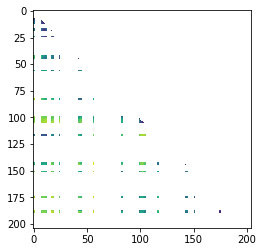

In [191]:

n_clusters = 34
n_channels = info['nchan']

n_members = n_channels//n_clusters

tadj = adj.copy()

for i in range(tadj.shape[0]):
    for j in range(tadj.shape[1]):
        if i <= j:
            tadj[i, j] = None

groups = list()
i = 0
for j, ch_name in enumerate(info['ch_names']):
    
    if j < i:
        continue
    if i < j:
        i = j
    
    if np.all(tadj[i, :] == None) or np.all(np.isnan(tadj[i, :])):
        continue
    
    group = [ch_name]
    
    
    mins = sorted([val for val in tadj[:, i] if val is not None and not np.isnan(val)])
    if len(mins) > n_members:
        mins = mins[:n_members]
        
    n = 0
    for k in range(i+1, tadj.shape[0]):
        
        if tadj[k, i] in mins:
            
            n += 1
            if n == n_members:
                break
            
            tadj[:, k] = None
            tadj[k, :] = None
            group.append(info['ch_names'][k])
    
    i+=n
    
    groups.append(np.array(group))
    
    tadj[i, :] == None
    
    if n < n_members:
        print(f'{n=}, {mins=}, {i=}')
        print(tadj[:, i])
        break
    
    
    # if ii == 0:
    #     plt.imshow(tadj)
    #     plt.show()
    # if ii == 1:
    #     plt.imshow(tadj)
    #     plt.show()
    #     break
    

plt.imshow(tadj)
print(len(groups))
print(len(groups[0]))
print(groups[-1], groups[-2])